Spatial step size: 50.0
Time step size: 0.03


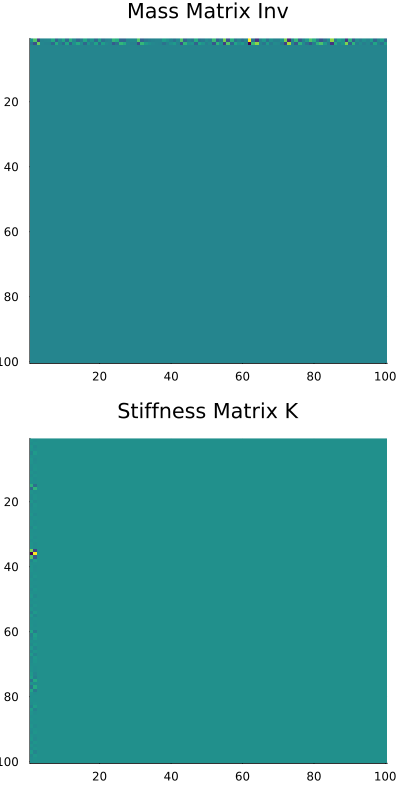

In [2]:
using LinearAlgebra
using Plots

# Basic parameters
vs = 500    # Wave velocity [m/s] 
f = 1.0        # Central frequency of the source (in Hz)
λ = vs / f      # Wavelength

# Adjust the spatial and temporal parameters to satisfy the CFL condition
ep = 0.3  # stability limit
dx = 0.1 * λ   # spatial step size (about 1/10 of a wavelength)  
dt = ep * dx / vs  # Time step size based on the CFL condition

xmax = 10000.0  # Maximum spatial coordinate (in meters)
t_max = 10.0    # Maximum simulation time (in seconds)

println("Spatial step size: $dx")
println("Time step size: $dt")

# Create random spatial coordinates
num_nodes = 100
x = rand(num_nodes) * xmax

# Initialize other parameters
h = diff(x)
ro0 = 1000   # Density [kg/m^3]
ro = x .* 0 .+ ro0  # Initialize density array
young_mod = x .* 0 .+ ro .* vs .^ 2  # Calculate Young's modulus from density and velocity

# Initialize time axis
t = range(dt, stop=t_max, length=round(Int, t_max / dt))

u = zeros(num_nodes)
uold = zeros(num_nodes)
unew = zeros(num_nodes)

# Source term (simple Ricker wavelet)
function ricker_wavelet(t, f, tau=2.0)
    A = (1 - 2 * pi^2 * f^2 * (t - tau)^2)
    wavelet = A * exp(-pi^2 * f^2 * (t - tau)^2)
    return wavelet
end

function linear_basis(xi)
    return [(1 - xi) / 2, (1 + xi) / 2]
end

function jacobian(x1, x2)
    return (x2 - x1) / 2
end

function gauss_legendre_quadrature()
    # Points and weights for Gauss-Legendre quadrature with two points
    points = [-1 / sqrt(3), 1 / sqrt(3)]
    weights = [1.0, 1.0]

    return points, weights
end

function mass_matrix(x1, x2, rho, A)
    points, weights = gauss_legendre_quadrature()

    M = zeros(2, 2)

    for k in 1:2
        xi = points[k]
        w = weights[k]

        basis_values = linear_basis(xi)

        for i in 1:2
            for j in 1:2
                M[i, j] += w * basis_values[i] * basis_values[j] * rho * A * jacobian(x1, x2)
            end
        end
    end

    return M
end

function stiffness_matrix(x1, x2, ym)
    points, weights = gauss_legendre_quadrature()
    basis_derivatives = [-1 / 2, 1 / 2]
    
    K = zeros(2, 2)
    
    for (etta, w) in zip(points, weights)
        dN_dx = basis_derivatives / jacobian(x1, x2)
        
        K += w * ym * (dN_dx * dN_dx') * jacobian(x1, x2)
    end
    
    return K
end

function global_matrix(x, ro, young_mod)
    num_nodes = length(x)
    M_global = zeros(num_nodes, num_nodes)
    K_global = zeros(num_nodes, num_nodes)
    
    for i in 1:num_nodes-1
        x1, x2 = x[i], x[i+1]
        M_e = mass_matrix(x1, x2, ro[i], h[i])
        K_e = stiffness_matrix(x1, x2, young_mod[i])

        for (local_i, global_i) in enumerate(i:i+1)
            for (local_j, global_j) in enumerate(1:1+1)
                M_global[global_i, global_j] += M_e[local_j, local_i]
                K_global[global_i, global_j] += K_e[local_i, local_j]
            end
        end
    end
    
    return M_global, K_global
end

# Invert M using pseudoinverse
mass_matrices, stiffness_matrices = global_matrix(x, ro, young_mod)
mass_matrices_inv = pinv(mass_matrices)

# Time stepping function
function time_stepping(x, young_mod, ro, t_max, dt)
    M, K = global_matrix(x, ro, young_mod)
    num_nodes = length(x)
    
    u = zeros(num_nodes)
    uold = copy(u)
    
    M_inv = pinv(M)
    time_series = 0:dt:t_max
    u_time = zeros(length(time_series), length(x))
    
    for (it, t) in enumerate(time_series)
        # Source input in force
        F = zeros(num_nodes)
        F[round(Int, num_nodes/2)] = ricker_wavelet(t, f)
        
        unew = dt^2 * M_inv * (F - K * u) + 2 * u - uold
        
        uold, u = u, unew
        u_time[it, :] = u
    end
    
    return u_time
end

# Perform time stepping
u_time = time_stepping(x, young_mod, ro, t_max, dt)

# Plot results or perform other analysis as needed
# ...

# Plot mass matrix and stiffness matrix in one plot
plot(
    heatmap(mass_matrices_inv, title="Mass Matrix Inv", color=:viridis, legend=false, yflip=true),
    heatmap(stiffness_matrices, title="Stiffness Matrix K", color=:viridis, legend=false, yflip=true),
    layout=(2, 1), size=(400, 800)
)
